In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

sqlite DB에서 데이터 불러오기

In [2]:
con = sqlite3.connect(r"C:\Users\구남이\OneDrive\바탕 화면\활동들\한이음 멘토링\stock.db")
df = pd.read_sql("SELECT * FROM '039490'", con, index_col=None)
df.rename(columns={'index':'date'}, inplace=True)
df = df.set_index('date')
df

,open,high,low,close,volume
date,,,,,
20220517,85000,87600,85000,87600,55677
20220516,86900,87600,85700,85900,55383
20220513,84000,87400,83500,85800,86525
20220512,84700,85300,82700,83200,104007
20220511,87500,87500,85500,85800,108071
...,...,...,...,...,...
20040429,5117,5436,5025,5101,109911
20040428,5071,5452,4995,5444,182604
20040427,5452,5482,5033,5063,299489


In [3]:
df.index = pd.DatetimeIndex(df.index)
df.index
df.sort_index(ascending=True, inplace=True)
df

,open,high,low,close,volume
date,,,,,
2004-04-23,6076,6799,5353,5353,1415109
2004-04-26,5436,5741,5261,5398,343283
2004-04-27,5452,5482,5033,5063,299489
2004-04-28,5071,5452,4995,5444,182604
2004-04-29,5117,5436,5025,5101,109911
...,...,...,...,...,...
2022-05-11,87500,87500,85500,85800,108071
2022-05-12,84700,85300,82700,83200,104007
2022-05-13,84000,87400,83500,85800,86525


데이터 시각화

Text(0, 0.5, 'price')

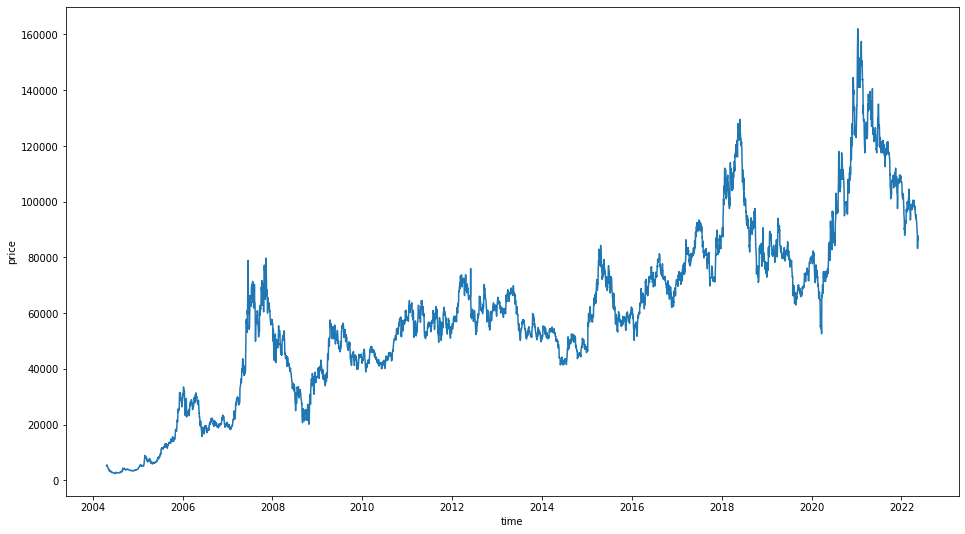

In [4]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

In [5]:
from sklearn.preprocessing import MinMaxScaler

# 피처값 스케일링
scaler = MinMaxScaler()

scaled_df = pd.DataFrame()
scaled_df[['open','high','low','volume']] = scaler.fit_transform(df[['open','high','low','volume']])

# 타켓 스케일링
scaler1 = MinMaxScaler()
scaled_df['close'] = scaler1.fit_transform(df['close'].values.reshape(-1,1))

# 스케일링 결과 확인
scaled_df

,open,high,low,volume,close
0,0.022741,0.026226,0.019066,1.000000,0.018324
1,0.018743,0.019815,0.018467,0.241077,0.018606
2,0.018842,0.018245,0.016982,0.210068,0.016507
3,0.016462,0.018063,0.016734,0.127305,0.018894
4,0.016750,0.017967,0.016930,0.075834,0.016745
...,...,...,...,...,...
4466,0.531437,0.515237,0.540941,0.074531,0.522470
4467,0.513944,0.501906,0.522709,0.071653,0.506176
4468,0.509571,0.514631,0.527918,0.059275,0.522470
4469,0.527689,0.515843,0.542243,0.037224,0.523096


In [6]:
def make_dataset(feature, label, window_size):
  feature_list = []
  label_list = []
  
  for i in range(len(feature) - window_size) :
    feature_list.append(feature.iloc[i:i+window_size])
    label_list.append(label.iloc[i+window_size])
  
  return np.array(feature_list), np.array(label_list)

In [7]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from tensorflow.keras import optimizers

def data(window_size):
    
    WINDOW_SIZE = window_size
    TEST_SIZE = 200
    
    train = scaled_df[:-TEST_SIZE]
    test = scaled_df[-TEST_SIZE:]

    feature_cols = ['open','high','low','volume']
    label_cols = ['close']

    train_feature = train[feature_cols]
    train_label = train[label_cols]
    train_feature, train_label = make_dataset(train_feature, train_label, WINDOW_SIZE)
    
    test_feature = test[feature_cols]
    test_label = test[label_cols]
    test_feature , test_label = make_dataset(test_feature, test_label, WINDOW_SIZE)

    x_train, x_test, y_train, y_test = train_test_split(train_feature, train_label, test_size=0.3) 
    
    return train_feature, train_label, test_feature, test_label, x_train, x_test, y_train, y_test

__HyperOpt를 활용하는 주요 로직__

+ 첫째는 입력 변수명과 입력값의 검색 공간(Search Space) 설정이다.

+ 둘째는 목적 함수(Objective Function)의 설정이다.

+ 마지막으로 `목적 함수의 반환 최솟값을 가지는 최적 입력값을 유추`하는 것이다.

In [8]:
search_space = {
    'batch_size': hp.choice('bs', [10, 20, 30, 40]),
    'window_size': hp.choice('ws', [20,30,50,60,80]),
    'lstm1_nodes': hp.choice('units_lstm1', [20, 30, 40, 50, 60]),
    'lstm1_dropouts': hp.uniform('dos_lstm1',0,1),
    'lstm_layers': hp.choice('num_layers_lstm',[
        {
            'layers':'one', 
        },
        {
            'layers':'two',
            'lstm2_nodes': hp.choice('units_lstm2', [20, 30, 40, 50, 60]),
            'lstm2_dropouts': hp.uniform('dos_lstm2',0,1)  
        }
        ]),
    'dense_layers': hp.choice('num_layers_dense',[
        {
            'layers':'one'
        },
        {
            'layers':'two',
            'dense2_nodes': hp.choice('units_dense', [10,20,30,40,50])
        }
        ]),
    "lr": hp.uniform('lr',0,1),
    "epochs": hp.choice('epochs', [100, 150, 200, 250, 300]),
    "optimizer": hp.choice('optmz',["sgd", "rms"])
}

In [9]:
def create_model_hypopt(params):
    print("Trying params:",params)
    window_size = params["window_size"]
    train_feature, train_label, test_feature, test_label, x_train, x_test, y_train, y_test = data(window_size)
    
    lstm_model = Sequential()
    lstm_model.add(LSTM(params["lstm1_nodes"], 
                        input_shape=(train_feature.shape[1], train_feature.shape[2]),
                        dropout=params["lstm1_dropouts"],
                        recurrent_dropout=params["lstm1_dropouts"],  
                        return_sequences=True,
                        kernel_initializer='random_uniform'))  
    
    if params["lstm_layers"]["layers"] == "two":
        lstm_model.add(LSTM(params["lstm_layers"]["lstm2_nodes"], dropout=params["lstm_layers"]["lstm2_dropouts"]))
    else:
        lstm_model.add(Flatten())

    if params["dense_layers"]["layers"] == 'two':
        lstm_model.add(Dense(params["dense_layers"]["dense2_nodes"], activation='relu'))
    
    lstm_model.add(Dense(1, activation='sigmoid'))

    lr = params["lr"]
    epochs = params["epochs"]
    batch_size = params["batch_size"]
    
    if params["optimizer"] == 'rms':
        optimizer = optimizers.RMSprop(lr=lr)
    else:
        optimizer = optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5) 
    history = lstm_model.fit(x_train, y_train, 
                             epochs=epochs, 
                             batch_size=batch_size,
                             verbose=2, 
                             validation_data=(x_test, y_test),
                             callbacks=[early_stop])
    val_error = np.amin(history.history['val_loss']) 
    print('Best validation error of epoch:', val_error)
    return {'loss': val_error, 'status': STATUS_OK, 'model': lstm_model} # if accuracy use '-' sign

trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20, 
    trials=trials)

Trying params:                                        
{'batch_size': 40, 'dense_layers': {'dense2_nodes': 30, 'layers': 'two'}, 'epochs': 100, 'lr': 0.20367144179891405, 'lstm1_dropouts': 0.3630470933094805, 'lstm1_nodes': 20, 'lstm_layers': {'layers': 'one'}, 'optimizer': 'sgd', 'window_size': 30}
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 1/100                                           
75/75 - 14s - loss: 0.0094 - val_loss: 0.0013         

Epoch 2/100                                           
75/75 - 4s - loss: 0.0022 - val_loss: 0.0014          

Epoch 3/100                                           
75/75 - 4s - loss: 0.0021 - val_loss: 0.0010          

Epoch 4/100                                           
75/75 - 4s - loss: 0.0019 - val_loss: 0.0011          

Epoch 5/100                                           
75/75 - 6s - loss: 0.0020 - val_loss: 9.5720e-04      

Epoch 6/100                                           
75/75 - 6s - loss: 0.0019 - val_loss: 9.9549e-04      

Epoch 7/100                                           
75/75 - 4s - loss: 0.0019 - val_loss: 9.3340e-04      

Epoch 8/100                                           
75/75 - 4s - loss: 0.0019 - val_loss: 9.2348e-04      

Epoch 9/100                                           
75/75 - 3s - loss: 0.0018 - val_loss: 9.1498e-04      

E

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



149/149 - 15s - loss: 0.1576 - val_loss: 0.1496                                     

Epoch 2/150                                                                         
149/149 - 7s - loss: 0.1573 - val_loss: 0.1496                                      

Epoch 3/150                                                                         
149/149 - 7s - loss: 0.1573 - val_loss: 0.1496                                      

Epoch 4/150                                                                         
149/149 - 7s - loss: 0.1573 - val_loss: 0.1496                                      

Epoch 5/150                                                                         
149/149 - 7s - loss: 0.1573 - val_loss: 0.1496                                      

Epoch 6/150                                                                         
149/149 - 8s - loss: 0.1573 - val_loss: 0.1496                                      

Best validation error of epoch:                            

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



99/99 - 22s - loss: 0.1544 - val_loss: 0.1589                                       

Epoch 2/250                                                                         
99/99 - 13s - loss: 0.1549 - val_loss: 0.1589                                       

Epoch 3/250                                                                         
99/99 - 14s - loss: 0.1549 - val_loss: 0.1589                                       

Epoch 4/250                                                                         
99/99 - 13s - loss: 0.1549 - val_loss: 0.1589                                       

Epoch 5/250                                                                         
99/99 - 13s - loss: 0.1549 - val_loss: 0.1589                                       

Epoch 6/250                                                                         
99/99 - 13s - loss: 0.1549 - val_loss: 0.1589                                       

Best validation error of epoch:                            

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



147/147 - 38s - loss: 0.0410 - val_loss: 0.0330                                    

Epoch 2/150                                                                        
147/147 - 23s - loss: 0.0329 - val_loss: 0.0326                                    

Epoch 3/150                                                                        
147/147 - 23s - loss: 0.0332 - val_loss: 0.0337                                    

Epoch 4/150                                                                        
147/147 - 23s - loss: 0.0328 - val_loss: 0.0372                                    

Epoch 5/150                                                                        
147/147 - 24s - loss: 0.0332 - val_loss: 0.0326                                    

Epoch 6/150                                                                        
147/147 - 26s - loss: 0.0328 - val_loss: 0.0334                                    

Epoch 7/150                                                           

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 1/200                                                                         
75/75 - 19s - loss: 0.0187 - val_loss: 0.0049                                       

Epoch 2/200                                                                         
75/75 - 4s - loss: 0.0091 - val_loss: 0.0028                                        

Epoch 3/200                                                                         
75/75 - 4s - loss: 0.0080 - val_loss: 0.0035                                        

Epoch 4/200                                                                         
75/75 - 4s - loss: 0.0083 - val_loss: 0.0022                                        

Epoch 5/200                                                                         
75/75 - 4s - loss: 0.0074 - val_loss: 0.0033                                        

Epoch 6/200                                                                         
75/75 - 4s - loss: 0.0075 - val_loss: 0.0025                

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



149/149 - 24s - loss: 0.0064 - val_loss: 0.0011                                     

Epoch 2/250                                                                         
149/149 - 9s - loss: 0.0026 - val_loss: 0.0024                                      

Epoch 3/250                                                                         
149/149 - 9s - loss: 0.0023 - val_loss: 0.0012                                      

Epoch 4/250                                                                         
149/149 - 9s - loss: 0.0023 - val_loss: 0.0010                                      

Epoch 5/250                                                                         
149/149 - 9s - loss: 0.0021 - val_loss: 0.0017                                      

Epoch 6/250                                                                         
149/149 - 9s - loss: 0.0021 - val_loss: 8.2486e-04                                  

Epoch 7/250                                                

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



100/100 - 21s - loss: 0.1544 - val_loss: 0.1330                                     

Epoch 2/200                                                                         
100/100 - 5s - loss: 0.0751 - val_loss: 0.0536                                      

Epoch 3/200                                                                         
100/100 - 5s - loss: 0.0450 - val_loss: 0.0458                                      

Epoch 4/200                                                                         
100/100 - 5s - loss: 0.0423 - val_loss: 0.0338                                      

Epoch 5/200                                                                         
100/100 - 5s - loss: 0.0418 - val_loss: 0.0334                                      

Epoch 6/200                                                                         
100/100 - 5s - loss: 0.0412 - val_loss: 0.0505                                      

Epoch 7/200                                                

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



148/148 - 19s - loss: 0.0210 - val_loss: 0.0030                                     

Epoch 2/150                                                                         
148/148 - 11s - loss: 0.0032 - val_loss: 0.0027                                     

Epoch 3/150                                                                         
148/148 - 12s - loss: 0.0030 - val_loss: 0.0026                                     

Epoch 4/150                                                                         
148/148 - 11s - loss: 0.0029 - val_loss: 0.0024                                     

Epoch 5/150                                                                         
148/148 - 11s - loss: 0.0027 - val_loss: 0.0024                                     

Epoch 6/150                                                                         
148/148 - 11s - loss: 0.0026 - val_loss: 0.0022                                     

Epoch 7/150                                                

KeyboardInterrupt: 

하이퍼 파라미터 확인

In [ ]:
best

{'bs': 1,
 'dos_lstm1': 0.002312280212046436,
 'epochs': 1,
 'lr': 0.8828559067739363,
 'num_layers_dense': 1,
 'num_layers_lstm': 0,
 'optmz': 0,
 'units_dense': 3,
 'units_lstm1': 3,
 'ws': 0}

In [ ]:
bs = {0:30, 1:40, 2:50, 3:60, 4:70}
ws = {0:20, 1:30, 2:50, 3:60, 4:80}
units_lstm1 = {0:10, 1:20, 2:30, 3:40}
num_layers_lstm = {0: 'one', 1:'two'}
units_lstm2 = {0:20, 1:30, 2:40, 3:50}
num_layers_dense = {0:'one', 1:'two'}
units_dense = {0:10, 1:20, 2:30, 3:40}
epochs = {0:100, 1:150, 2:200, 3:250, 4:300}
optmz = {0:"sgd", 1:"rms"}

In [ ]:
batch_size = bs[best["bs"]]
window_size = ws[best["ws"]]
train_feature, train_label, test_feature, test_label, x_train, x_test, y_train, y_test = data(window_size)
    
lstm_model = Sequential()
lstm_model.add(LSTM(units_lstm1[best['units_lstm1']], 
                    input_shape=(train_feature.shape[1], train_feature.shape[2]),
                    dropout=best["dos_lstm1"],
                    recurrent_dropout=best["dos_lstm1"],  
                    return_sequences=True,
                    kernel_initializer='random_uniform'))  
    
if num_layers_lstm[best['num_layers_lstm']] == "two":
    lstm_model.add(LSTM(units_lstm2[best['units_lstm2']], dropout=best['dos_lstm2']))
else:
    lstm_model.add(Flatten())

if num_layers_dense[best['num_layers_dense']] == 'two':
    lstm_model.add(Dense(units_dense[best['units_dense']], activation='relu'))
    
lstm_model.add(Dense(1, activation='sigmoid'))

lr = best["lr"]
epochs = epochs[best['epochs']]
if optmz[best['optmz']] == 'rms':
    optimizer = optimizers.RMSprop(lr=lr)
else:
    optimizer = optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)  # binary_crossentropy
    
early_stop = EarlyStopping(monitor='val_loss', patience=10) 
history = lstm_model.fit(x_train, y_train, 
                             epochs=epochs, 
                             verbose=2, 
                             validation_data=(x_test, y_test),
                             callbacks=[early_stop])



c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/150
93/93 - 15s - loss: 0.0055 - val_loss: 0.0010
Epoch 2/150
93/93 - 3s - loss: 7.3416e-04 - val_loss: 5.8458e-04
Epoch 3/150
93/93 - 3s - loss: 6.0310e-04 - val_loss: 0.0012
Epoch 4/150
93/93 - 3s - loss: 5.3241e-04 - val_loss: 5.1258e-04
Epoch 5/150
93/93 - 3s - loss: 4.7378e-04 - val_loss: 4.4150e-04
Epoch 6/150
93/93 - 3s - loss: 4.6021e-04 - val_loss: 3.8697e-04
Epoch 7/150
93/93 - 2s - loss: 4.1912e-04 - val_loss: 3.8851e-04
Epoch 8/150
93/93 - 4s - loss: 3.9853e-04 - val_loss: 3.6485e-04
Epoch 9/150
93/93 - 4s - loss: 3.7724e-04 - val_loss: 6.4078e-04
Epoch 10/150
93/93 - 4s - loss: 3.8456e-04 - val_loss: 3.2483e-04
Epoch 11/150
93/93 - 3s - loss: 3.6591e-04 - val_loss: 3.8360e-04
Epoch 12/150
93/93 - 3s - loss: 3.3351e-04 - val_loss: 3.0085e-04
Epoch 13/150
93/93 - 3s - loss: 3.3705e-04 - val_loss: 2.8633e-04
Epoch 14/150
93/93 - 3s - loss: 3.2876e-04 - val_loss: 2.8064e-04
Epoch 15/150
93/93 - 3s - loss: 3.4446e-04 - val_loss: 3.0328e-04
Epoch 16/150
93/93 - 3s - loss

In [ ]:
y_pred = lstm_model.predict(test_feature)

스케일링 전 값으로 역변환

In [ ]:
rescaled_y_true = scaler1.inverse_transform(np.array(test_label).reshape(-1,1))
rescaled_y_pred = scaler1.inverse_transform(np.array(y_pred).reshape(-1,1))

In [ ]:
rescaled_y_pred.shape

(180, 1)

In [ ]:
rescaled_y_true.shape

(180, 1)

평가지표 계산

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [ ]:
confirm_result(rescaled_y_true, rescaled_y_pred)

,Results
MAE,1821.01749
RMSE,2323.57643
RMSLE,0.02294
R2,0.92208


시각화

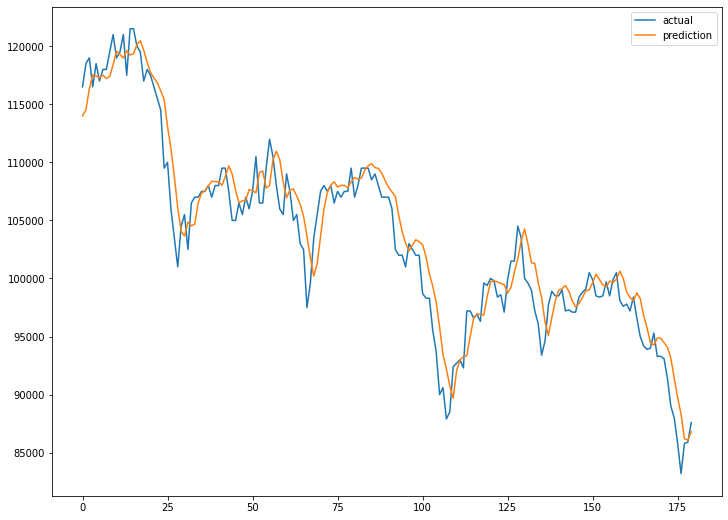

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(rescaled_y_true, label='actual')
plt.plot(rescaled_y_pred, label='prediction')
plt.legend()
plt.show()